In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# #importing my Opschaler module
# import sys
# sys.path.append('/home/16080696/notebooks/KB-74-OPSCHALER/')
# import Opschaler as op

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import tensorflow as tf
from keras.layers.core import Dense, Activation, Flatten
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import optimizers
from livelossplot import PlotLossesKeras


Using TensorFlow backend.


In [2]:
df = pd.read_csv("/datc/opschaler/combined_gas_smart_weather_dfs/processed/all_dwellings_combined_hour.csv",delimiter="\t", parse_dates = ['datetime'])

df = df.set_index(['datetime'])
#making the gaspower more readable (scaling)
df['gasPower'] = df['gasPower']*10

df = df.resample('1D').mean()
df.head()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,gasMeter,DD,DR,FF,...,Q,RG,SQ,T,T10,TD,U,VV,WW,gasPower
datetime,,,,,,,,,,,,,,,,,,,,,
2017-02-22,1438.456541,0.0,1667.423814,0.0,172.213024,0.0,1678.402532,243.553846,410.153846,8.478718,...,36.371795,1.026923,0.000000,9.315385,9.052564,8.276923,92.807692,10240.384615,50.064102,2.562459
2017-02-23,1558.435883,0.0,1805.226395,0.0,173.374907,0.0,1685.894847,239.148194,265.916667,11.608438,...,24.312500,0.461319,0.149737,8.590000,8.163889,6.441597,86.511805,12887.305430,41.759722,4.857127
2017-02-24,1561.837229,0.0,1806.231979,0.0,246.992340,0.0,1694.890589,278.093543,45.766667,5.032826,...,107.562499,0.054306,2.962413,4.746250,3.968194,2.241736,83.740972,28850.902303,13.997222,2.768300
2017-02-25,1564.963013,0.0,1808.506632,0.0,150.144606,0.0,1698.313894,202.265418,14.750000,6.502271,...,49.312501,0.002083,0.361316,5.606806,4.653194,2.398264,79.870832,28918.541423,9.211111,0.171661
2017-02-26,1564.963013,0.0,1817.410950,0.0,679.171475,0.0,1706.148254,208.350207,82.633334,7.540049,...,24.770834,0.098611,0.039483,8.688750,8.264306,6.636181,86.559028,20726.805461,17.117361,5.030009


In [3]:
def dummies(df):
    df['T-1'] = df['T'].shift(1)

    #Creating hour of the day and day of the week variables
    df['hour'] = df.index.hour #creating a column that takes the hour of the day from the DateTime index
    df['dayofweek'] = df.index.dayofweek #same but with the day of the week, obviously

    #Creating dummyvariables out of the columns above (meaning making a ones-matrix from the columns)
    add_columns = ['hour', 'dayofweek'] #making variable for the columns
    df[add_columns] = df[add_columns].astype('category') #in order to make dummy variables, they need to be of the type category
    df = pd.get_dummies(df, columns=add_columns)
    return df

df = dummies(df)
df = df.dropna()
df.head()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,gasMeter,DD,DR,FF,...,gasPower,T-1,hour_0,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
datetime,,,,,,,,,,,,,,,,,,,,,
2017-02-23,1558.435883,0.0,1805.226395,0.0,173.374907,0.0,1685.894847,239.148194,265.916667,11.608438,...,4.857127,9.315385,1,0,0,0,1,0,0,0
2017-02-24,1561.837229,0.0,1806.231979,0.0,246.992340,0.0,1694.890589,278.093543,45.766667,5.032826,...,2.768300,8.590000,1,0,0,0,0,1,0,0
2017-02-25,1564.963013,0.0,1808.506632,0.0,150.144606,0.0,1698.313894,202.265418,14.750000,6.502271,...,0.171661,4.746250,1,0,0,0,0,0,1,0
2017-02-26,1564.963013,0.0,1817.410950,0.0,679.171475,0.0,1706.148254,208.350207,82.633334,7.540049,...,5.030009,5.606806,1,0,0,0,0,0,0,1
2017-02-27,1566.147619,0.0,1828.823593,0.0,253.032893,0.0,1711.548060,192.541318,111.916667,7.891396,...,1.315816,8.688750,1,1,0,0,0,0,0,0


In [4]:
X = df[['T','T-1','dayofweek_0','dayofweek_1','dayofweek_2','dayofweek_3','dayofweek_4','dayofweek_5','dayofweek_6']]
y = df[['gasPower']]

y = np.array(y)

train_size = 0.7

split_index = int(df.shape[0]*train_size)

X_train = X[:split_index]
y_train = y[:split_index]

X_test = X[split_index:]
y_test = y[split_index:]

len(y_test)

84

In [ ]:
#normalizing the data
#scalerX = StandardScaler(with_mean=True, with_std=True).fit(X_train)

X_train = np.array(X_train).reshape(len(X_train),9)
X_train = tf.keras.utils.normalize(X_train, axis=1)

X_test = np.array(X_test).reshape(len(X_test),9)
X_test = tf.keras.utils.normalize(X_test, axis=1)

y_train = np.array(y_train)
y_test = np.array(y_test)


X_train.shape


(193, 9)

In [ ]:
model = Sequential()
model.add(Dense (120, input_dim=9, activation='relu', kernel_initializer='TruncatedNormal')) #90 smoother than 300, but 300 getting better results
model.add(Dense (16, activation='sigmoid')) #16 optimal so far
model.add(Dense (1))


In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

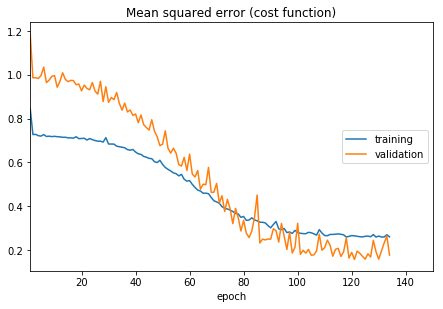

In [ ]:
model.fit(X_train, y_train, epochs=150, batch_size=10,verbose=0, validation_data = (X_test, y_test), callbacks = [PlotLossesKeras()])

#Getting the datetimes for the splits
X_datetime=df.index[:len(X_train)]
X1_datetime=df.index[len(X_train):]

#predict actual values
Y_prediction=model.predict(X_test)

# %matplotlib notebook
plt.figure(figsize=(20,11))
plt.plot(X1_datetime,y_test,'.-',alpha=0.4,color='r',label='TEST DATA')
plt.plot(X1_datetime,Y_prediction,'.-',alpha=0.7,color='b',label='PREDICTED DATA')     


plt.grid(True)
plt.title('1 DAY PREDICTION \n T,T-1, DAY OF THE WEEK \nMSE: '+ str(mean_squared_error(y_test,Y_prediction)))
plt.xlabel( 'Datetime')
plt.xticks(rotation='vertical' )
plt.ylabel('gasPower [m$^3$ per hour]')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('DNN_results_without_y_scaling.png', dpi=1200)
plt.show()



In [ ]:
print(min(y_train), max(y_train))